This notebook is from created from the TensorFlow tutorial:
http://tensorflow.org/tutorials/mnist/pros/index.md

Import the MNIST Data

In [1]:
import input_data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Get size of training data

In [3]:
mnist.train.num_examples

55000

Get size of test data

In [4]:
mnist.test.num_examples

10000

Display size of training images tensor

In [5]:
mnist.train.images.shape

(55000, 784)

In [6]:
mnist.train.labels.shape

(55000, 10)

In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
first_image_array = mnist.train.images[0, ]
image_length = int(np.sqrt(first_image_array.size))
first_image = np.reshape(first_image_array, (-1, image_length))

In [9]:
first_image.shape

(28, 28)

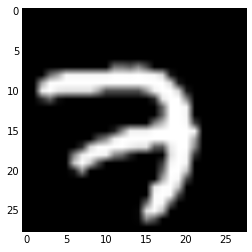

In [10]:
plt.imshow(first_image, cmap = cm.Greys_r)
plt.show()

## Variables

In [11]:
import tensorflow as tf
#set up an interactive session
sess = tf.InteractiveSession()

#set up first the softmax regression model with a single linear layer

#create nodes for the input impages and target output classes [these are placeholders]
x = tf.placeholder("float", [None, 784])
y_ = tf.placeholder("float", [None,10])

#now create the variables for the linear model: y = Wx + b
#these are initialized as zeros

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

# initialize all the variables
sess.run(tf.initialize_all_variables())


## Predicted Class and Cost Function

In [12]:
# set up the regression model and the cross-entroy cost function
y = tf.nn.softmax(tf.matmul(x,W)+b)

cross_entropy = -tf.reduce_sum(y_*tf.log(y))

## Train the Model

In [13]:
# set up the training to minimize the cost function and run the training for 1000 steps

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)# run the training for 1000 times

for i in range(1000):
    batch = mnist.train.next_batch(50)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

## Evaluate the Model

In [14]:
# check the model by comparing which of predicted (highest probability) are equal to actual labels in the test set

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_, 1))

# go ahead and cast this to get the mean accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

print accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})

0.9092


This is 90.92% or 9.08% error. Compare this to error rates on http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

# Build a Multilayer Convolutional Network

## Weight Initialization

In [15]:
# want some random slightly non-zero weights to remove symmetry and 0 gradients.
# also slightly positive bias to avoid "dead neurons". Generate a couple functions to do this.

def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)
    
def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)


## Convolution and Pooling

In [16]:
# choose vanilla versions relative to convolution and pooling operations
# i.e. max pooling over 2x2 block

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


## First Convolution Layer

In [17]:
# first layer: convolution followed by max pooling: 32 features for each 5x5 patch
# shape [5, 5, 1, 32]

W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])

# to apply, reshape x to a 4d tensor (second and third dimensions are image width and height)
x_image = tf.reshape(x, [-1,28,28,1])

# convolve x_image with weight tensor, add bias, apply ReLU fn and max pool
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

## Second Convolution Layer

In [18]:
# to build a deep network stack several layer. 2nd layer will have 64 features per 5x5 patch

W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

## Densely Connected Layer

In [19]:
# now that image is reduced to 7x7, we add fully connected layer with 1024 neurons to process entire image

W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout

In [20]:
#apply dropout to reduce overfitting
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## Readout Layer

In [23]:
# add softmax layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# Train and Evaluate the Model

In [ ]:
# This training takes about 1 3/4 hours on a 2.8 GHz Intel Core i7 (4 core)
#
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.initialize_all_variables())

acc = []
num_train = 20000

startTime = time.clock()
print time.strftime("%Y-%m-%d %H:%M:%S")

for i in range(num_train):
    batch = mnist.train.next_batch(50)
    if i%500 == 0 and i != 0:
        train_accuracy = accuracy.eval(feed_dict={
                x:batch[0], y_: batch[1], keep_prob: 1.0})
        test_accuracy = accuracy.eval(feed_dict={
                x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
        print "step %5d, training accuracy %8.3f, test accuracy %8.3f"%(i, train_accuracy, test_accuracy)
        acc.append(test_accuracy)
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

endTime = time.clock()
print time.strftime("%Y-%m-%d %H:%M:%S")

print "test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
print "Time to run: %f s" % (endTime - startTime)

2015-11-13 12:55:29
step   500, training accuracy    0.920, test accuracy    0.952

In [ ]:
import pandas as pd

acc = pd.Series(acc)
plt.figure()
plt.ylim(0.9, 1.01)
p=acc.plot()

The final test set accuracy should be approximately 99.2%